In [1]:
from datasets import load_dataset


dataset = load_dataset("mstz/adult", "income")["train"].to_pandas()
dataset.head()

/home/ms/.virtualenvs/macerata/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,age,capital_gain,capital_loss,education,final_weight,hours_worked_per_week,marital_status,native_country,occupation,race,relationship,is_male,workclass,over_threshold
0,43,0.0,0.0,10,34278,35,Married-civ-spouse,United-States,Sales,White,Husband,True,Private,0
1,23,0.0,0.0,3,244698,35,Never-married,Mexico,Farming-fishing,White,Other-relative,True,Private,0
2,39,0.0,0.0,10,118286,40,Married-civ-spouse,United-States,Sales,Black,Husband,True,Private,0
3,35,0.0,0.0,9,126675,46,Divorced,?,Craft-repair,White,Not-in-family,True,Private,0
4,66,0.0,0.0,13,28367,99,Married-civ-spouse,United-States,Priv-house-serv,White,Other-relative,True,Private,0


In [2]:
# categorizing workers
dataset.loc[dataset.hours_worked_per_week < 50, "time"] = "regular"
dataset.loc[(dataset.hours_worked_per_week > 50) & (dataset.hours_worked_per_week < 75), "time"] = "overtime"
dataset.loc[(dataset.hours_worked_per_week >= 75) & (dataset.hours_worked_per_week < 90), "time"] = "workaholic"
dataset.loc[dataset.hours_worked_per_week > 90, "time"] = "burnt"

Protip: we can automatically discretize! See [pandas.qcut](https://pandas.pydata.org/docs/reference/api/pandas.qcut.html) for reference.

In [3]:
dataset.loc[dataset.capital_gain < 3000, "capital_gain_rank"] = 0
dataset.loc[(dataset.capital_gain > 3000) & (dataset.capital_gain < 5500), "capital_gain_rank"] = 1
dataset.loc[(dataset.capital_gain >= 5500) & (dataset.capital_gain < 10000), "capital_gain_rank"] = 2
dataset.loc[dataset.capital_gain > 10000, "capital_gain_rank"] = 3

# Data understanding

Data understanding is a crucial component of data science: it allows us to get a deeper glance of the data, thus allowing us to performed informed proccessing.

`pandas.crosstab` (reference [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html)) computes a cross-function between sequences.
By default, the function is frequency.

This comes very handy to understand relationships between pairs of variables, e.g., working hours and future income.

<Axes: xlabel='time'>

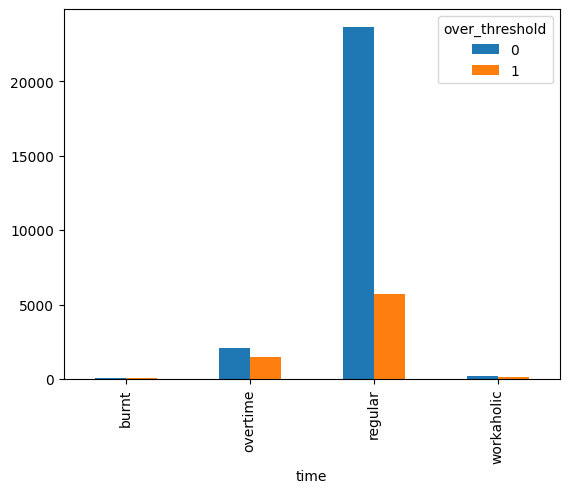

In [39]:
from pandas import crosstab


work_hours_by_threshold = crosstab(dataset["time"], dataset["over_threshold"])
work_hours_by_threshold.plot(kind="bar")

<Axes: xlabel='time'>

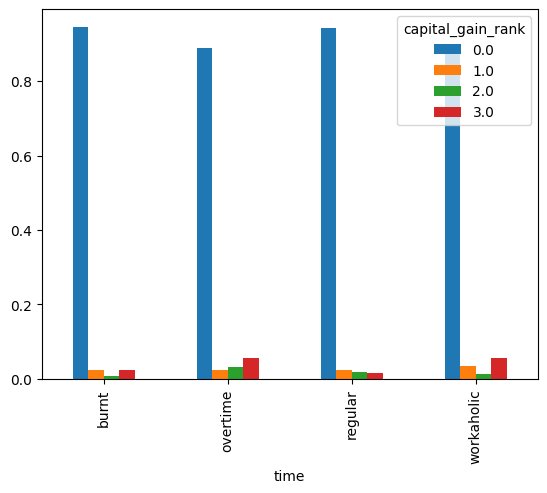

In [41]:
work_hours_by_capital_gain = crosstab(dataset["time"], dataset["capital_gain_rank"]).astype("float")
work_hours_by_capital_gain.loc["burnt", :] = work_hours_by_capital_gain.loc["burnt", :] / work_hours_by_capital_gain.loc["burnt", :].sum()
work_hours_by_capital_gain.loc["regular", :] = work_hours_by_capital_gain.loc["regular", :] / work_hours_by_capital_gain.loc["regular", :].sum()
work_hours_by_capital_gain.loc["overtime", :] = work_hours_by_capital_gain.loc["overtime", :] / work_hours_by_capital_gain.loc["overtime", :].sum()
work_hours_by_capital_gain.loc["workaholic", :] = work_hours_by_capital_gain.loc["workaholic", :] / work_hours_by_capital_gain.loc["workaholic", :].sum()

work_hours_by_capital_gain.plot(kind="bar")

<Axes: xlabel='time'>

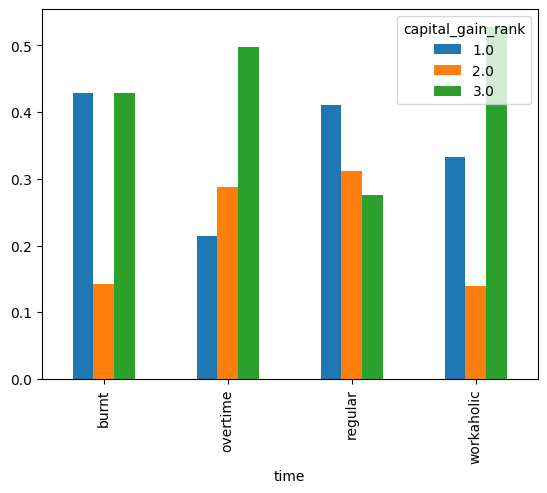

In [42]:
high_earners = dataset[dataset["capital_gain_rank"] > 0]

work_hours_by_capital_gain = crosstab(high_earners["time"], high_earners["capital_gain_rank"]).astype("float")
work_hours_by_capital_gain.loc["burnt", :] = work_hours_by_capital_gain.loc["burnt", :] / work_hours_by_capital_gain.loc["burnt", :].sum()
work_hours_by_capital_gain.loc["regular", :] = work_hours_by_capital_gain.loc["regular", :] / work_hours_by_capital_gain.loc["regular", :].sum()
work_hours_by_capital_gain.loc["overtime", :] = work_hours_by_capital_gain.loc["overtime", :] / work_hours_by_capital_gain.loc["overtime", :].sum()
work_hours_by_capital_gain.loc["workaholic", :] = work_hours_by_capital_gain.loc["workaholic", :] / work_hours_by_capital_gain.loc["workaholic", :].sum()

work_hours_by_capital_gain.plot(kind="bar")

<Axes: xlabel='time'>

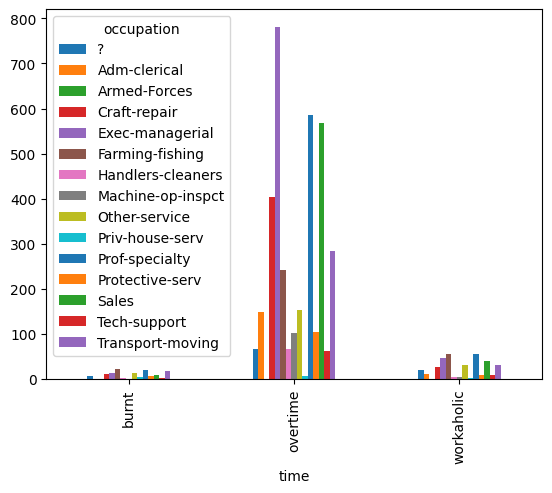

In [44]:
high_workers = dataset[dataset["time"] != "regular"]

capital_gain_by_occupation = crosstab(high_workers["time"], high_workers["occupation"])
capital_gain_by_occupation.plot(kind="bar")

<Axes: xlabel='is_male'>

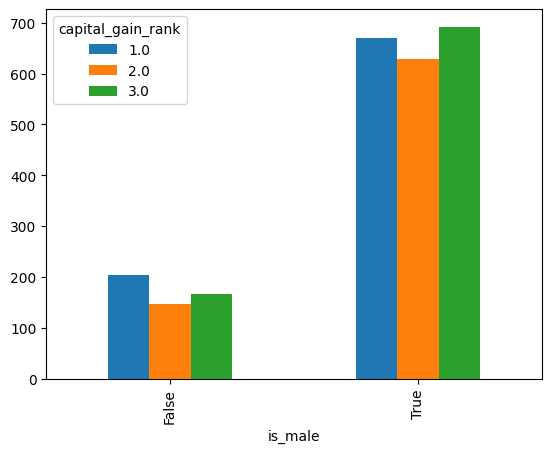

In [46]:
high_earners = dataset[dataset["capital_gain_rank"] > 0]

capital_gain_by_sex = crosstab(high_earners["is_male"], high_earners["capital_gain_rank"])
capital_gain_by_sex.plot(kind="bar")

<Axes: xlabel='marital_status'>

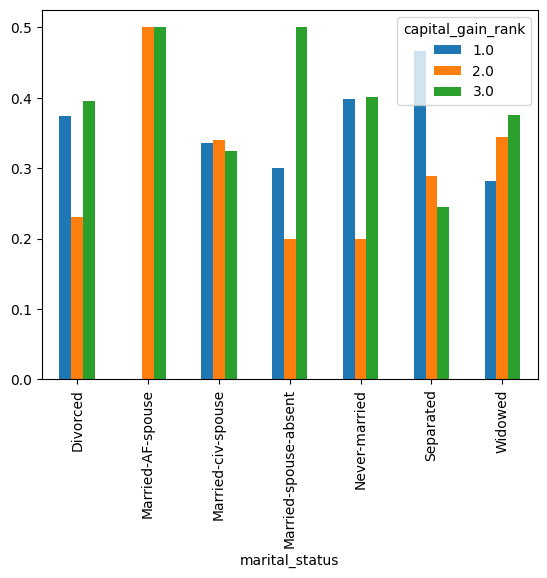

In [48]:
high_earners = dataset[dataset["capital_gain_rank"] > 0]

capital_gain_by_status = crosstab(high_earners["marital_status"], high_earners["capital_gain_rank"])
capital_gain_by_status = capital_gain_by_status.div(capital_gain_by_status.sum(axis=1), axis=0)
capital_gain_by_status.plot(kind="bar")

# Groups

Often, we want to reason in terms of groups, e.g., "What is the mean capital of young people?"
Rather than extracting all of them, and then work individually on each group, we can directly create groups on our `DataFrame`, and work from there.

In [35]:
dataset.groupby(["native_country", "capital_gain_rank"]).describe()

age                                     \
                                  count       mean        std   min    25%   
native_country capital_gain_rank                                             
?              0.0                606.0  38.141914  12.515762  17.0  28.00   
               1.0                  8.0  40.125000   9.478359  29.0  33.25   
               2.0                 20.0  46.350000  10.209773  34.0  38.00   
               3.0                 23.0  47.000000  10.591592  30.0  41.00   
Cambodia       0.0                 18.0  33.944444   7.779855  25.0  28.00   
...                                 ...        ...        ...   ...    ...   
Vietnam        1.0                  3.0  47.333333   9.073772  37.0  44.00   
               3.0                  1.0  23.000000        NaN  23.0  23.00   
Yugoslavia     0.0                 10.0  37.200000  12.318008  19.0  29.25   
               1.0                  2.0  53.000000   2.828427  51.0  52.00   
               2.0                  1.0  66.000000        NaN  66.0  66.00   

                                                    capital_gain  \
                                   50%    75%   max        count   
native_country capital_gain_rank                                   
?              0.0                36.0  45.00  88.0        606.0   
               1.0                37.5  47.75  55.0          8.0   
               2.0                45.5  54.00  66.0         20.0   
               3.0                45.0  51.00  66.0         23.0   
Cambodia       0.0                32.5  37.00  51.0         18.0   
...                                ...    ...   ...          ...   
Vietnam        1.0                51.0  52.50  54.0          3.0   
               3.0                23.0  23.00  23.0          1.0   
Yugoslavia     0.0                35.0  47.00  56.0         10.0   
               1.0                53.0  54.00  55.0          2.0   
               2.0                66.0  66.00  66.0          1.0   

                                                ... hours_worked_per_week  \
                                          mean  ...                   75%   
native_country capital_gain_rank                ...                         
?              0.0                   44.813531  ...                 45.00   
               1.0                 4373.000000  ...                 45.00   
               2.0                 7653.400000  ...                 45.75   
               3.0                52858.521739  ...                 52.50   
Cambodia       0.0                    0.000000  ...                 40.00   
...                                        ...  ...                   ...   
Vietnam        1.0                 3751.000000  ...                 80.50   
               3.0                14344.000000  ...                 40.00   
Yugoslavia     0.0                    0.000000  ...                 50.25   
               1.0                 3916.500000  ...                 32.00   
               2.0                 5556.000000  ...                 40.00   

                                       over_threshold                      \
                                   max          count      mean       std   
native_country capital_gain_rank                                            
?              0.0                99.0          606.0  0.207921  0.406155   
               1.0                80.0            8.0  0.500000  0.534522   
               2.0                60.0           20.0  1.000000  0.000000   
               3.0                60.0           23.0  1.000000  0.000000   
Cambodia       0.0                75.0           18.0  0.333333  0.485071   
...                                ...            ...       ...       ...   
Vietnam        1.0                84.0            3.0  0.000000  0.000000   
               3.0                40.0            1.0  1.000000       NaN   
Yugoslavia     0.0                65.0           10.0  0.400000 

In [11]:
dataset.groupby("capital_gain_rank").describe()

age                                                \
                     count       mean        std   min   25%   50%   75%   
capital_gain_rank                                                          
0.0                34125.0  38.252777  13.781958  17.0  27.0  36.0  47.0   
1.0                  873.0  41.712486  11.487170  18.0  33.0  40.0  50.0   
2.0                  775.0  44.689032  11.141100  21.0  36.0  43.0  51.0   
3.0                  858.0  46.473193  11.799268  17.0  38.0  46.0  53.0   

                        capital_gain                ... hours_worked_per_week  \
                    max        count          mean  ...                   75%   
capital_gain_rank                                   ...                         
0.0                90.0      34125.0     31.772278  ...                  45.0   
1.0                78.0        873.0   4162.324170  ...                  45.0   
2.0                90.0        775.0   7569.163871  ...                  50.0   
3.0                90.0        858.0  34276.307692  ...                  55.0   

                        over_threshold                                     \
                    max          count      mean       std  min  25%  50%   
capital_gain_rank                                                           
0.0                99.0        34125.0  0.201993  0.401493  0.0  0.0  0.0   
1.0                99.0          873.0  0.363116  0.481173  0.0  0.0  0.0   
2.0                96.0          775.0  0.913548  0.281211  0.0  1.0  1.0   
3.0                99.0          858.0  0.987179  0.112565  0.0  1.0  1.0   

                             
                   75%  max  
capital_gain_rank            
0.0                0.0  1.0  
1.0                1.0  1.0  
2.0                1.0  1.0  
3.0                1.0  1.0  

[4 rows x 56 columns]

# Visualization library: Bokeh
`bokeh` ([https://bokeh.org](https://bokeh.org)) is a visualization library to create interactive plots.

Provides several types of plots:
- [scatter](https://docs.bokeh.org/en/latest/docs/reference/models/glyphs/scatter.html#scatter)
- [line](https://docs.bokeh.org/en/latest/docs/reference/models/glyphs/line.html)
- [bar plots](https://docs.bokeh.org/en/latest/docs/reference/models/glyphs/vbar.html)

In [12]:
from bokeh.plotting import figure  # drawing board
from bokeh.plotting import show
from bokeh.io import output_notebook

output_notebook()


def draw_scatter_plot(x, y, title, label_x, label_y, legend):
    p = figure(title=title,
               x_axis_label=label_x,
               y_axis_label=label_y)
    p.scatter(x, y,
              legend_label=legend,
              line_width=3,
              line_dash="solid",
              marker="triangle",
              color="red",
              size=20,
              fill_alpha=.25,
              line_alpha=.25)

    return p


loss, gain = dataset["capital_loss"].values, dataset["capital_gain"].values
show(draw_scatter_plot(loss, gain,
                       title="Capital: loss VS gain",
                       label_x="loss",
                       label_y="gain",
                       legend="capital"))

Loading BokehJS ...

In [13]:
from bokeh.models import ColumnDataSource
from bokeh.io import curdoc
from bokeh.models import LinearAxis, VBar
import numpy


def draw_bar_plot(x, y, title, label_x, label_y):
    p = figure(title=title,
               x_axis_label=label_x,
               y_axis_label=label_y)
    source = ColumnDataSource(dict(x=x,top=y))
    glyph = VBar(x="x", top="top",
                 bottom=0,
                 width=1.,
                 fill_color="red")
    p.add_glyph(source, glyph)

    curdoc().add_root(p)

    return p

ages, age_frequencies = numpy.unique(dataset["age"].values, return_counts=True)
age_frequencies = age_frequencies / age_frequencies.sum()

p = draw_bar_plot(ages, age_frequencies,
                  title="Age frequencies",
                  label_x="age",
label_y="frequency")

show(p)

In [14]:
mean_gains = list(map(lambda age: dataset[dataset["age"] == age]["capital_gain"].values.mean(), ages))
p = draw_bar_plot(ages, mean_gains,
                  title="Average income per age",
                  label_x="age",
                  label_y="Mean income")

show(p)

These are only some of many! [Here](https://docs.bokeh.org/en/latest/docs/gallery.html) you find a lot of examples.

## Pandas visualization
Some visualizations are so common that `pandas` developers have already integrated them!
Reference [here](https://pandas.pydata.org/docs/user_guide/visualization.html).

#### Density

In [ ]:
dataset["age"].plot.kde()

#### Histograms

In [ ]:
dataset["capital_gain"].hist(bins=25)

In [ ]:
from pandas.plotting import scatter_matrix


numeric_dataset = dataset.select_dtypes(include="number")
scatter_matrix(numeric_dataset, diagonal="kde", figsize=(12, 12))